<a href="https://colab.research.google.com/github/Harsha194/Elevate_Labs_Tasks/blob/main/Stock_Trends_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3-600244557.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0390 - val_loss: 0.0200 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0080 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0046 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0035 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0030 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0032 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0026 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0026 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0028 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 10/1

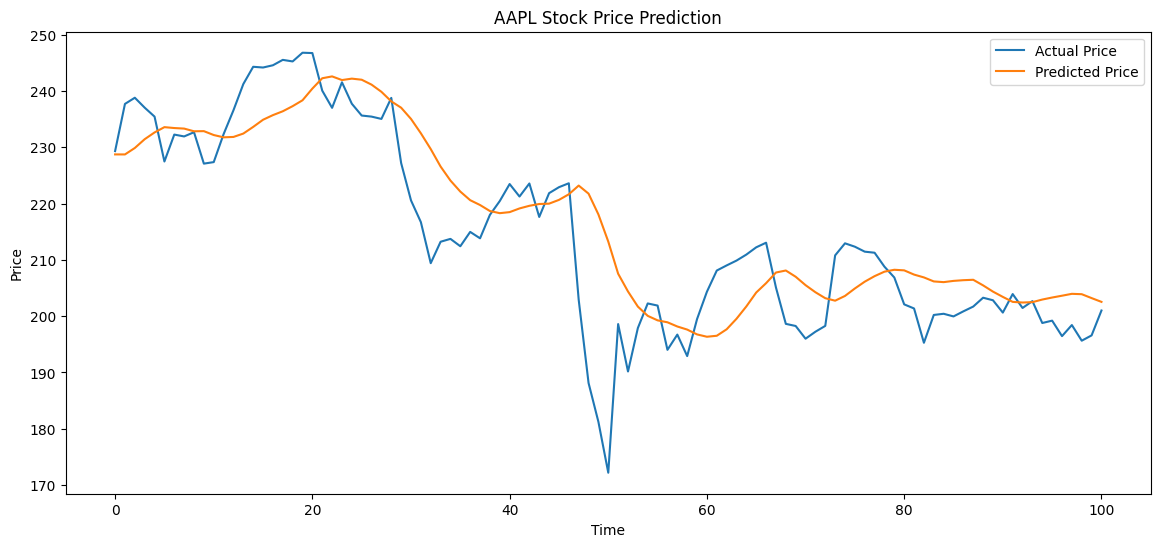

Test MSE: 92.6037
Test MAE: 6.9190
Test MAPE: 3.3353%


In [ ]:
# Stock Price Prediction with LSTM
# Google Colab Notebook

# Install required packages
!pip install yfinance pandas numpy matplotlib seaborn tensorflow streamlit

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Collection
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data from Yahoo Finance
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Parameters
ticker = 'AAPL'  # Example stock (Apple)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')  # 5 years data

# Fetch data
stock_data = fetch_stock_data(ticker, start_date, end_date)

# 2. Feature Engineering
def add_technical_indicators(df):
    """
    Add technical indicators to the dataframe
    """
    # Moving Averages
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    df['MA_200'] = df['Close'].rolling(window=200).mean()

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp12 = df['Close'].ewm(span=12, adjust=False).mean()
    exp26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df.dropna()

# Add technical indicators
stock_data = add_technical_indicators(stock_data)

# 3. Data Preprocessing
def prepare_data(df, look_back=60):
    """
    Prepare data for LSTM model
    """
    # Select features
    features = ['Close', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line']
    data = df[features].values

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, :])
        y.append(scaled_data[i, 0])  # Predicting 'Close' price

    X, y = np.array(X), np.array(y)

    # Train-test split (80-10-10)
    train_size = int(0.8 * len(X))
    val_size = int(0.1 * len(X))

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

X_train, y_train, X_val, y_val, X_test, y_test, scaler = prepare_data(stock_data)

# 4. Model Building
def build_lstm_model(input_shape):
    """
    Build LSTM model architecture
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

# 5. Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 6. Model Evaluation
def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate model performance
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform predictions
    dummy_test = np.zeros((len(y_pred), len(scaler.scale_)))
    dummy_test[:, 0] = y_pred.flatten()
    y_pred_actual = scaler.inverse_transform(dummy_test)[:, 0]

    # Inverse transform actual values
    dummy_test[:, 0] = y_test.flatten()
    y_test_actual = scaler.inverse_transform(dummy_test)[:, 0]

    # Calculate metrics
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

    # Plot results
    plt.figure(figsize=(14, 6))
    plt.plot(y_test_actual, label='Actual Price')
    plt.plot(y_pred_actual, label='Predicted Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return mse, mae, mape, y_test_actual, y_pred_actual

mse, mae, mape, y_test_actual, y_pred_actual = evaluate_model(model, X_test, y_test, scaler)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.4%}")

# 7. Save Model and Artifacts
model.save('stock_lstm_model.h5')

import joblib
joblib.dump(scaler, 'scaler.pkl')

# Save test results for Streamlit app
np.save('y_test_actual.npy', y_test_actual)
np.save('y_pred_actual.npy', y_pred_actual)

# Save the last window for future predictions
last_window = X_test[-1]
np.save('last_window.npy', last_window)

# Save the dates for plotting
test_dates = stock_data.index[-len(y_test_actual):]
np.save('test_dates.npy', test_dates)